In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.colab import auth
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

auth.authenticate_user()

project_id = 'data-analytics-mate'
client = bigquery.Client(project = project_id)

query = """

SELECT date, s.ga_session_id , sp.continent, sp.country, sp.device, sp.browser, sp.mobile_model_name, sp.operating_system, sp.language, sp.medium, sp.channel, acs.account_id,
COALESCE(is_verified, 0) as verification,
CASE
    WHEN (account_id IS NOT NULL AND is_unsubscribed = 0) THEN 1
    WHEN (account_id IS NOT NULL AND is_unsubscribed = 1) THEN 0
    ELSE NULL
END AS subscription,p.category, p.name, p.price,p.short_description
FROM `DA.session` s
LEFT JOIN `DA.session_params` sp
ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `DA.account_session` acs
ON s.ga_session_id = acs.ga_session_id
LEFT JOIN `DA.account` acc
ON acs.account_id = acc.id
LEFT JOIN `DA.order` o
ON s.ga_session_id = o.ga_session_id
LEFT JOIN `DA.product` p
ON o.item_id = p.item_id """


df = client.query(query).to_dataframe()

In [ ]:
df.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,verification,subscription,category,name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,0,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,0,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,<NA>,0,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,<NA>,0,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,<NA>,0,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  verification       349545 non-null  Int64  
 13  subscription       27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  name               33538 non-null   object 
 16  pr

In [ ]:
df["date"] = pd.to_datetime(df["date"])
total_columns = df.shape[1]
print(f"Number of columns: {total_columns}")

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"Numeric columns: {len(numeric_cols)}")
print(f"{numeric_cols}")

categorical_cols = df.select_dtypes(include='object').columns.tolist()
print(f"\nCategorical columns: {len(categorical_cols)}")
print(f"{categorical_cols}")

datetime_cols = df.select_dtypes(include='datetime').columns.tolist()
print(f"\nDatetime columns: {len(datetime_cols)}")
print(f"{datetime_cols}")

Number of columns: 18
Numeric columns: 5
['ga_session_id', 'account_id', 'verification', 'subscription', 'price']

Categorical columns: 12
['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'medium', 'channel', 'category', 'name', 'short_description']

Datetime columns: 1
['date']


In [ ]:
unique_sessions = df['ga_session_id'].nunique()
print(f"Unique sessions: {unique_sessions}")

start_date = df["date"].min().date()
end_date = df["date"].max().date()
print(f"\nTime period: from {start_date} to {end_date}")

Unique sessions: 349545

Time period: from 2020-11-01 to 2021-01-31


In [ ]:
missing_per_column = df.isnull().sum()
print(missing_per_column)

date                      0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
medium                    0
channel                   0
account_id           321600
verification              0
subscription         321600
category             316007
name                 316007
price                316007
short_description    316007
dtype: int64


The account_id column has the highest number of missing values, as many sessions come from guest users without an account. Additionally, a significant number of sessions do not include any orders, which leads to missing values in the category, name, price, and short_description columns because no order-related information is available. Since the sessions come from various countries, the language column also contains a considerable number of missing values.

In [ ]:
top_continents_by_revenue = df.groupby("continent")["price"].sum().reset_index(name="revenue").sort_values(by="revenue", ascending=False).head(3).reset_index(drop=True)
print(top_continents_by_revenue)

  continent     revenue
0  Americas  17665280.0
1      Asia   7601298.3
2    Europe   5934624.2


In [ ]:
top_countries_by_revenue = df.groupby("country")["price"].sum().reset_index(name="revenue").sort_values(by="revenue", ascending=False).head(5).reset_index(drop=True)
print(top_countries_by_revenue)

          country     revenue
0   United States  13943553.9
1           India   2809762.0
2          Canada   2437921.0
3  United Kingdom    938317.9
4          France    710692.8


<ipython-input-9-9f2b40a5a549>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_continents_by_revenue,x="continent",y="revenue",ax=axes[0],palette="Blues_d")
<ipython-input-9-9f2b40a5a549>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries_by_revenue,x="country",y="revenue",ax=axes[1],palette="Greens_d")


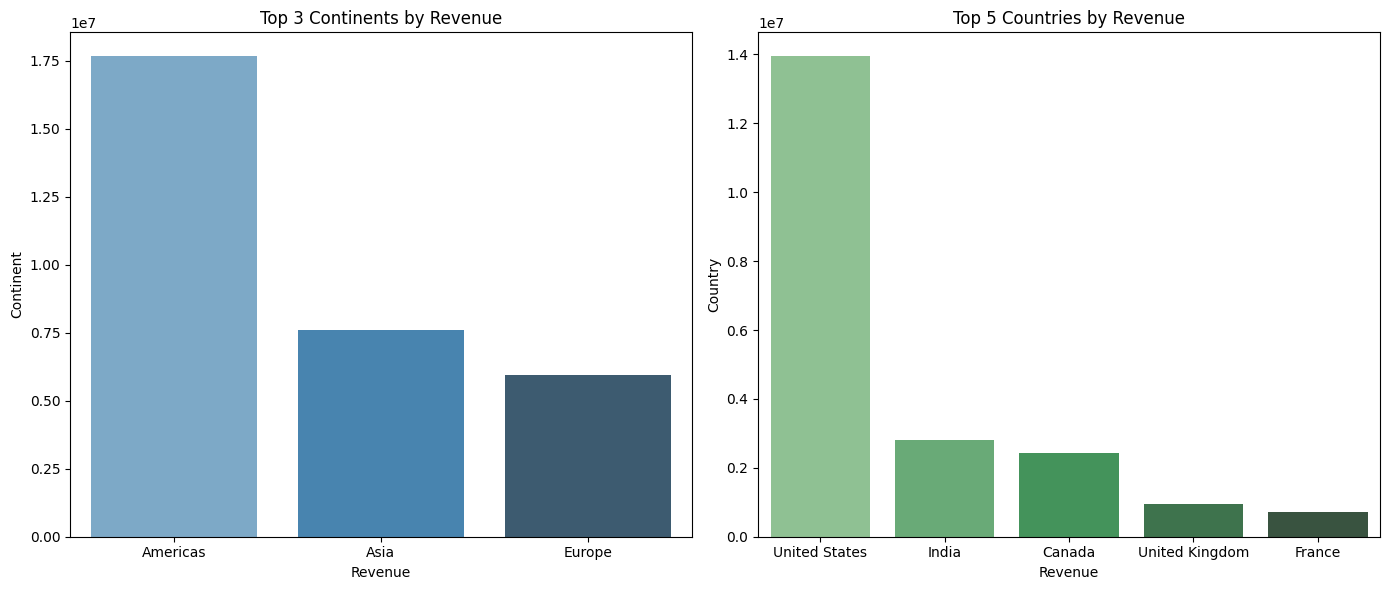

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=top_continents_by_revenue,x="continent",y="revenue",ax=axes[0],palette="Blues_d")
axes[0].set_title("Top 3 Continents by Revenue")
axes[0].set_xlabel("Revenue")
axes[0].set_ylabel("Continent")

sns.barplot(data=top_countries_by_revenue,x="country",y="revenue",ax=axes[1],palette="Greens_d")
axes[1].set_title("Top 5 Countries by Revenue")
axes[1].set_xlabel("Revenue")
axes[1].set_ylabel("Country")

plt.tight_layout()
plt.show()

In [ ]:
top_continents_by_orders = df[df["category"].notnull()].groupby("continent")["category"].count().reset_index(name="order_count").sort_values(by="order_count", ascending=False).reset_index(drop=True).head(3)
print(top_continents_by_orders)

  continent  order_count
0  Americas        18553
1      Asia         7950
2    Europe         6261


In [ ]:
top_countries_by_orders = df[df["category"].notnull()].groupby("country")["category"].count().reset_index(name="order_count").sort_values(by="order_count", ascending=False).reset_index(drop=True).head(5)
print(top_countries_by_orders)

          country  order_count
0   United States        14673
1           India         3029
2          Canada         2560
3  United Kingdom         1029
4          France          678


<ipython-input-12-0dc76a6dfed5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_continents_by_orders,x="order_count",y="continent",ax=axes[0],palette="Blues_d")
<ipython-input-12-0dc76a6dfed5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries_by_orders,x="order_count",y="country",ax=axes[1],palette="Greens_d")


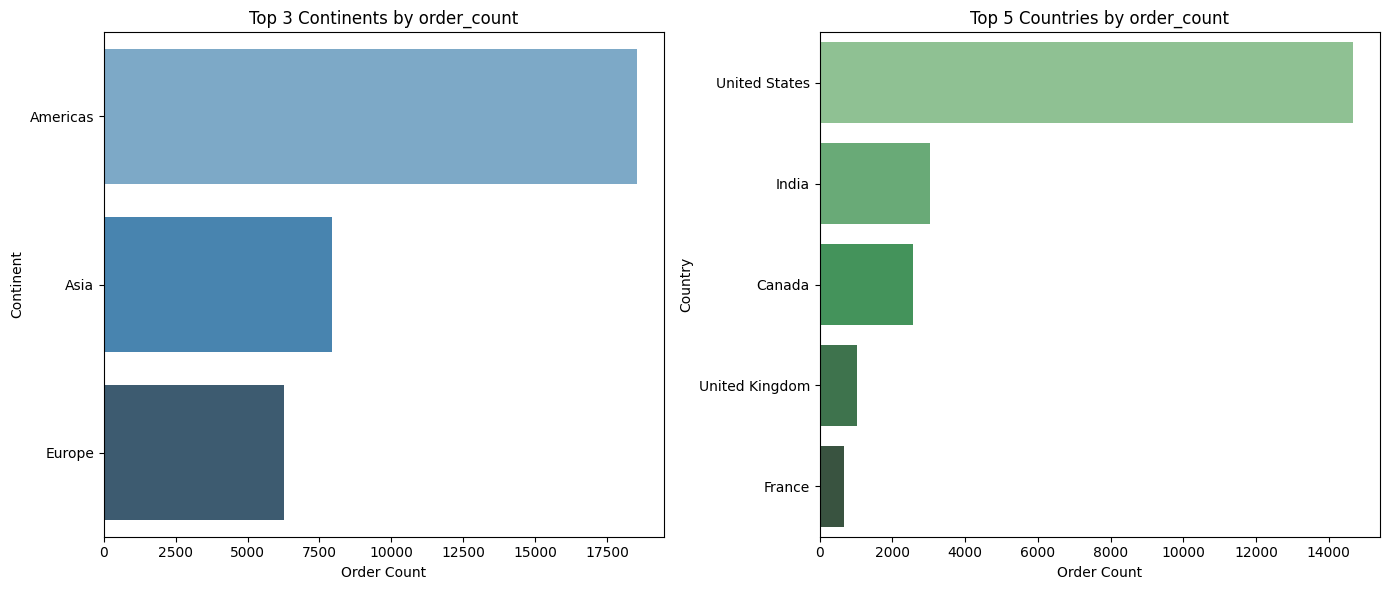

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=top_continents_by_orders,x="order_count",y="continent",ax=axes[0],palette="Blues_d")
axes[0].set_title("Top 3 Continents by order_count")
axes[0].set_xlabel("Order Count")
axes[0].set_ylabel("Continent")

sns.barplot(data=top_countries_by_orders,x="order_count",y="country",ax=axes[1],palette="Greens_d")
axes[1].set_title("Top 5 Countries by order_count")
axes[1].set_xlabel("Order Count")
axes[1].set_ylabel("Country")

plt.tight_layout()
plt.show()

In [ ]:
top_ten_categories_by_revenue = df.groupby("category")["price"].sum().reset_index(name="revenue").sort_values(by="revenue", ascending=False).reset_index(drop=True).head(10)
print(top_ten_categories_by_revenue)

                           category    revenue
0                 Sofas & armchairs  8388254.5
1                            Chairs  6147748.8
2                              Beds  4919725.0
3        Bookcases & shelving units  3640818.1
4              Cabinets & cupboards  2336499.5
5                 Outdoor furniture  2142222.2
6                    Tables & desks  1790307.5
7  Chests of drawers & drawer units   906562.5
8                     Bar furniture   735503.0
9              Children's furniture   467697.0


In [ ]:
top_categories_in_US =df[df["country"] == "United States"].groupby("category")["price"].sum().reset_index(name="revenue").sort_values(by="revenue", ascending=False).reset_index(drop=True).head(10)
print(top_categories_in_US)

                           category    revenue
0                 Sofas & armchairs  3707144.5
1                            Chairs  2619773.8
2                              Beds  2213058.0
3        Bookcases & shelving units  1567606.9
4              Cabinets & cupboards   994545.5
5                 Outdoor furniture   929245.2
6                    Tables & desks   777865.0
7  Chests of drawers & drawer units   382388.0
8                     Bar furniture   330805.0
9              Children's furniture   207575.0


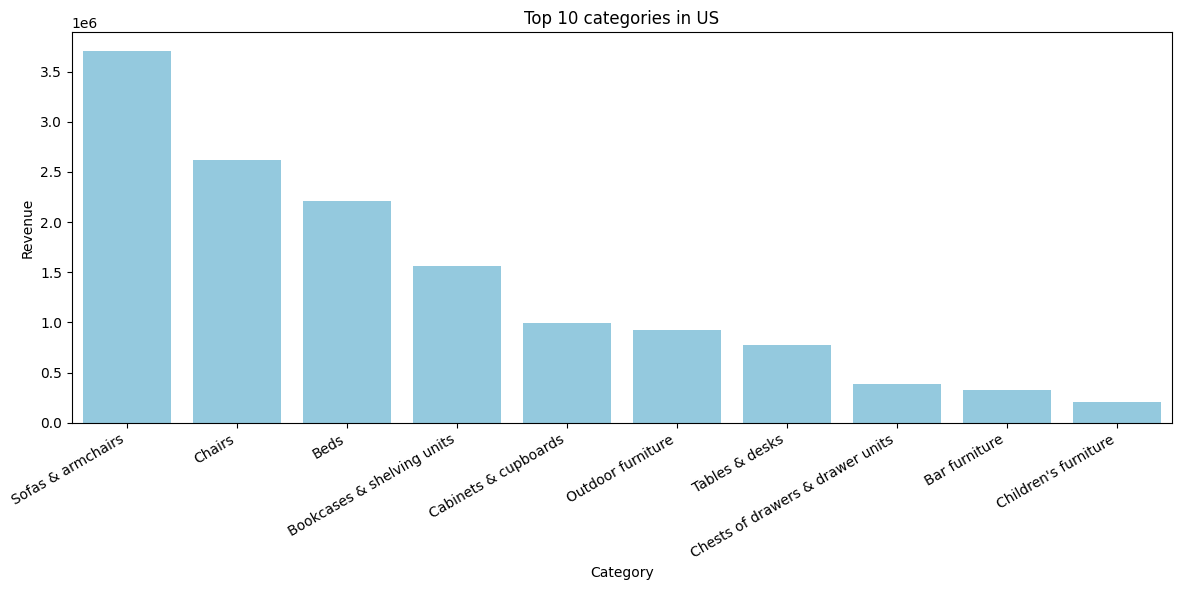

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_categories_in_US, x="category", y="revenue", color="skyblue")

plt.title("Top 10 categories in US")
plt.xlabel("Category")
plt.ylabel("Revenue")

plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

The United States leads all countries in both orders and revenue.General picture of top-revenue categories worldwide closely matches the category rankings observed specifically in the US.

In [ ]:
orders_by_devices = df[df["category"].notnull()].groupby("device")["ga_session_id"].count()
print(orders_by_devices)

device
desktop    19702
mobile     13113
tablet       723
Name: ga_session_id, dtype: Int64


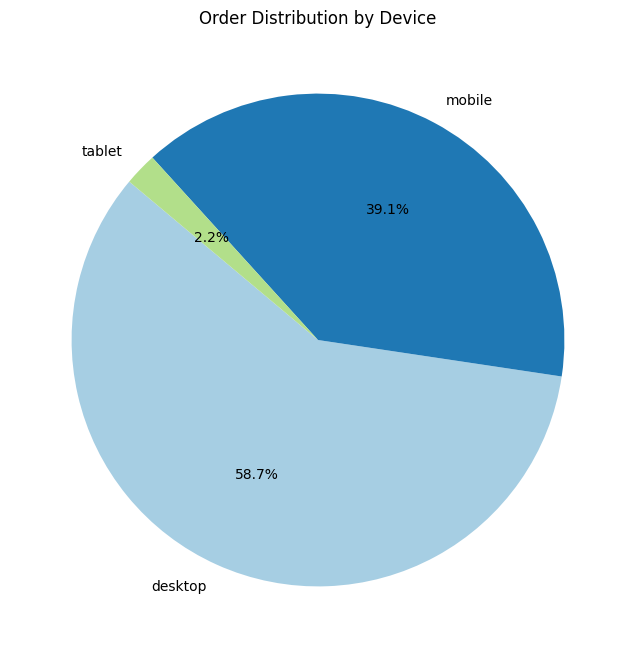

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(orders_by_devices, labels=orders_by_devices.index, autopct='%1.1f%%', startangle=140,colors=plt.cm.Paired.colors)

plt.title("Order Distribution by Device")
plt.show()

In [ ]:
orders_by_models = df[df["category"].notnull()].groupby("mobile_model_name")["ga_session_id"].count().sort_values(ascending=False)
print(orders_by_models)

mobile_model_name
Chrome        9359
Safari        6833
iPhone        6819
<Other>       6801
ChromeBook    1877
Edge           741
iPad           456
Firefox        430
Pixel 4 XL     117
Pixel 3        105
Name: ga_session_id, dtype: Int64


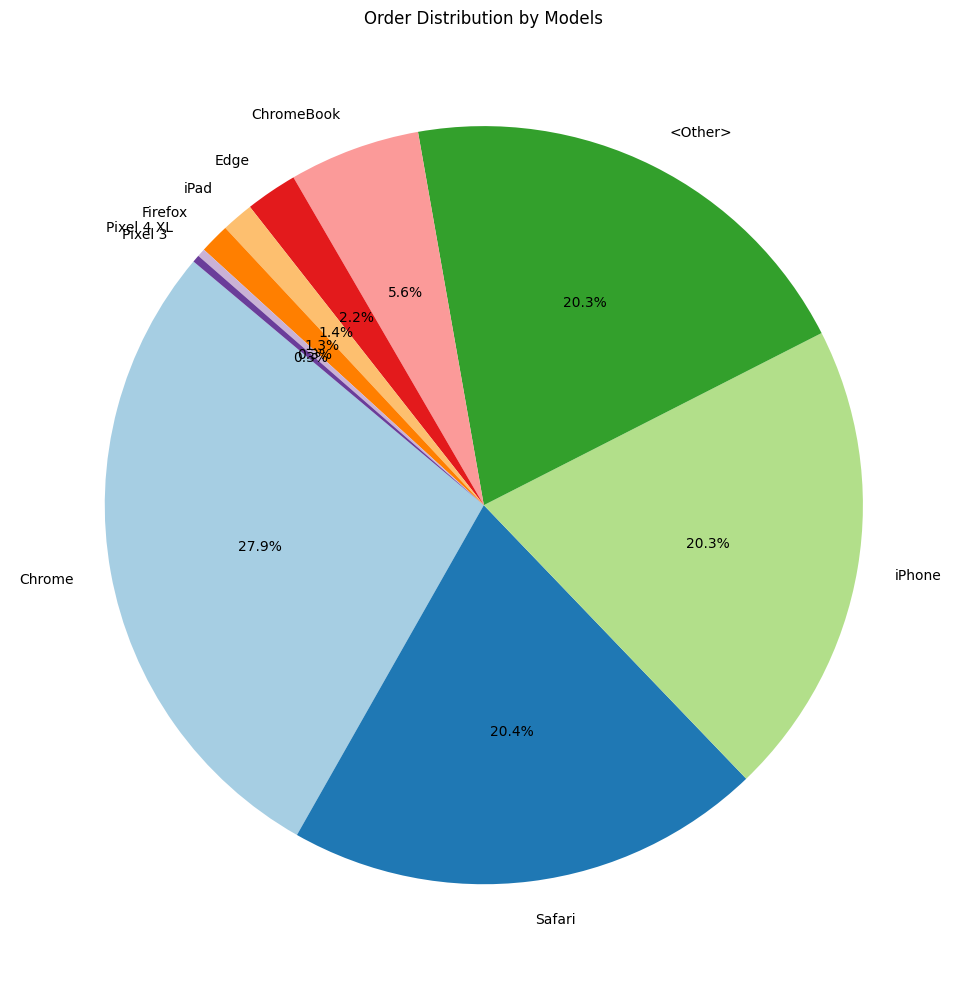

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(orders_by_models, labels=orders_by_models.index, autopct='%1.1f%%', startangle=140,colors=plt.cm.Paired.colors)

plt.title("Order Distribution by Models")
plt.tight_layout()
plt.show()

In [ ]:
orders_by_browser = df[df["category"].notnull()].groupby("browser")["ga_session_id"].count().sort_values(ascending=False)
print(orders_by_browser)

browser
Chrome             23015
Safari              7903
<Other>              865
Edge                 752
Firefox              583
Android Webview      420
Name: ga_session_id, dtype: Int64


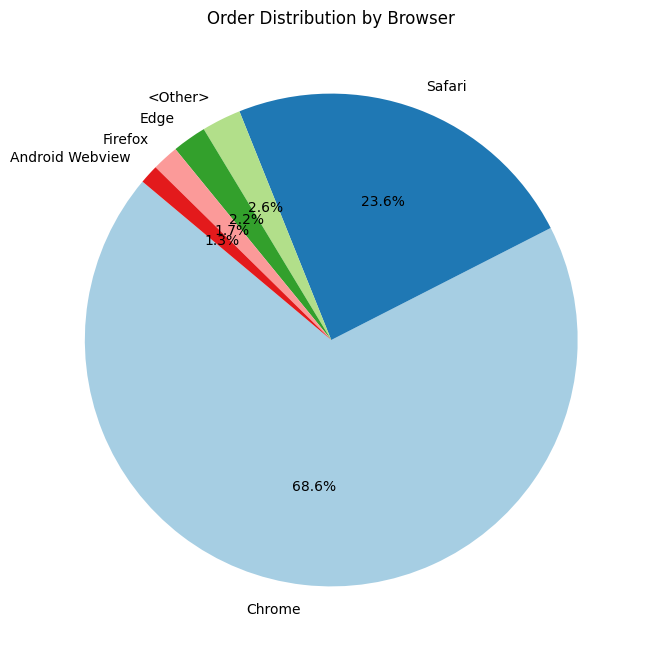

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(orders_by_browser, labels=orders_by_browser.index, autopct='%1.1f%%', startangle=140,colors=plt.cm.Paired.colors)

plt.title("Order Distribution by Browser")
plt.show()

In [ ]:
reg_users_count = df[df["account_id"].notnull()]["account_id"].nunique()
reg_users_with_email_count = df[df["account_id"].notnull() & df["verification"] == 1]["account_id"].nunique()

print(f"Percentage of users with confirmed email: {reg_users_with_email_count/reg_users_count * 100}%")

Percentage of users with confirmed email: 71.69797817140812%


In [ ]:
reg_users_unsubscribed = df[df["account_id"].notnull() & df["subscription"] == 0]["account_id"].nunique()
print(f"Percentage of unsubscribed users: {reg_users_unsubscribed/reg_users_count * 100}%")

Percentage of unsubscribed users: 16.94399713723385%


In [ ]:
count_of_orders_subscribed = df[(df["subscription"] == 1) & (df["price"].notnull())]["ga_session_id"].nunique()
count_of_orders_unsubscribed = df[(df["subscription"] == 0) & (df["price"].notnull())]["ga_session_id"].nunique()
print(count_of_orders_subscribed)
print(count_of_orders_unsubscribed)


2334
447


The behavior in terms of sales clearly differs, subscribed users (those still receiving emails) made significantly more purchases (2334 orders) compared to unsubscribed users (447 orders). This suggests that being subscribed positively influences user engagement and sales, indicating that email campaigns likely play an important role in driving customer activity and revenue.

In [ ]:
reg_users_by_countries = df.groupby("country")["account_id"].count().reset_index(name="reg_user_count").sort_values(by="reg_user_count", ascending=False).head(10)
print(reg_users_by_countries)

            country  reg_user_count
104   United States           12384
43            India            2687
18           Canada            2067
103  United Kingdom             859
33           France             553
92            Spain             536
96           Taiwan             500
20            China             490
35          Germany             490
48            Italy             386


<ipython-input-26-ece658d96b15>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reg_users_by_countries,x="country",y="reg_user_count",palette="viridis")


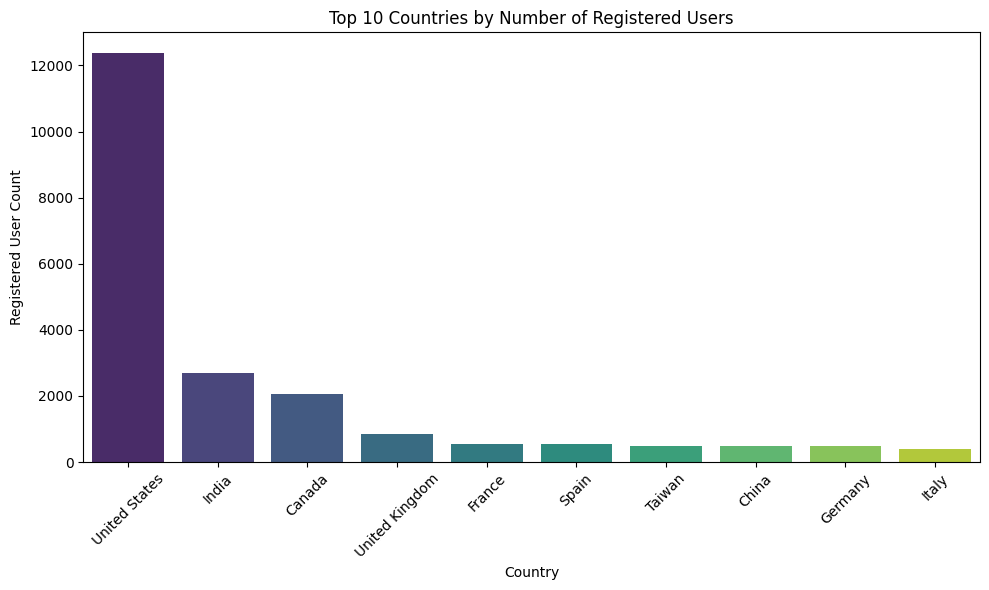

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=reg_users_by_countries,x="country",y="reg_user_count",palette="viridis")

plt.title("Top 10 Countries by Number of Registered Users")
plt.xlabel("Country")
plt.ylabel("Registered User Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
date_dynamic_revenue = df.groupby("date")["price"].sum()
print(date_dynamic_revenue)

date
2020-11-01    244292.5
2020-11-02    355506.8
2020-11-03    498979.6
2020-11-04    339187.1
2020-11-05    391276.6
                ...   
2021-01-27    286340.7
2021-01-28         0.0
2021-01-29         0.0
2021-01-30         0.0
2021-01-31         0.0
Name: price, Length: 92, dtype: float64


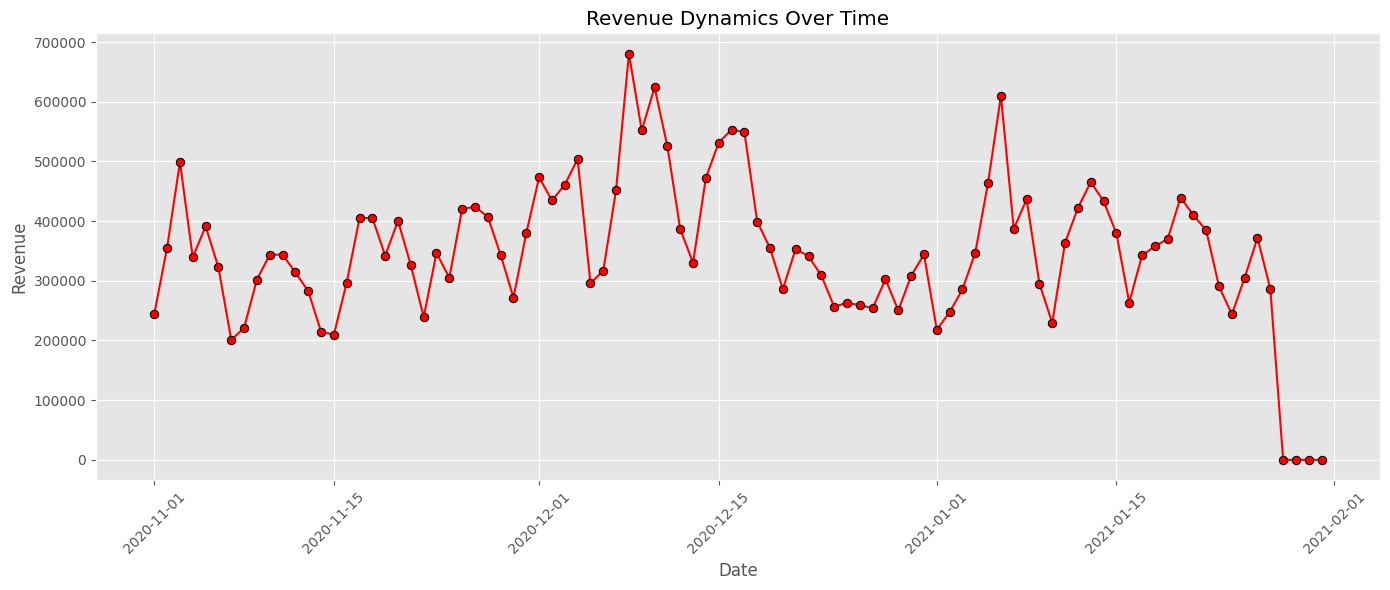

In [ ]:
plt.figure(figsize=(14, 6))
plt.style.use("ggplot")
sns.lineplot(x=date_dynamic_revenue.index,y=date_dynamic_revenue.values, marker="o",color="red",  markeredgecolor="black")

plt.title("Revenue Dynamics Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
date_dynamic_revenue = df.groupby("date")["ga_session_id"].count()
print(date_dynamic_revenue)

date
2020-11-01    2576
2020-11-02    3599
2020-11-03    5173
2020-11-04    4184
2020-11-05    3743
              ... 
2021-01-27    4435
2021-01-28    4112
2021-01-29    3700
2021-01-30    2845
2021-01-31    2812
Name: ga_session_id, Length: 92, dtype: Int64


Based on the chart, there is no strong visible correlation or clear seasonality in the revenue dynamics over time. However, noticeable spikes in revenue can be observed at the beginning of each month, suggesting a potential pattern linked to monthly cycles — possibly influenced by fresh budgets, salary periods, or new campaigns. Overall, while the revenue fluctuates quite a bit, the general trend remains irregular, and to confirm any underlying patterns or seasonality, a more detailed statistical analysis would be needed.

In [ ]:
sales_dynamic_by_continent = df.groupby("continent")["price"].sum().reset_index(name="revenue").sort_values(by="revenue", ascending=False)
print(sales_dynamic_by_continent)

   continent     revenue
2   Americas  17665280.0
3       Asia   7601298.3
4     Europe   5934624.2
5    Oceania    365230.2
1     Africa    331231.0
0  (not set)     74067.4


Text(0, 0.5, 'Continent')

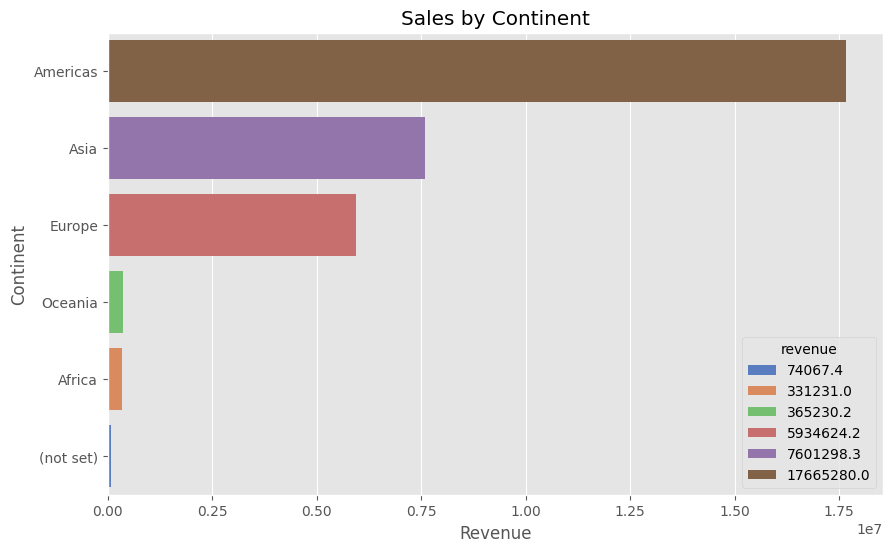

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=sales_dynamic_by_continent, x="revenue", y="continent", palette="muted", hue="revenue")

plt.title("Sales by Continent")
plt.xlabel("Revenue")
plt.ylabel("Continent")

          channel     revenue
1  Organic Search  11433151.6
2     Paid Search   8511049.4
0          Direct   7494923.4
3   Social Search   2532105.7
4       Undefined   2000501.0


Text(0.5, 0, 'Channel')

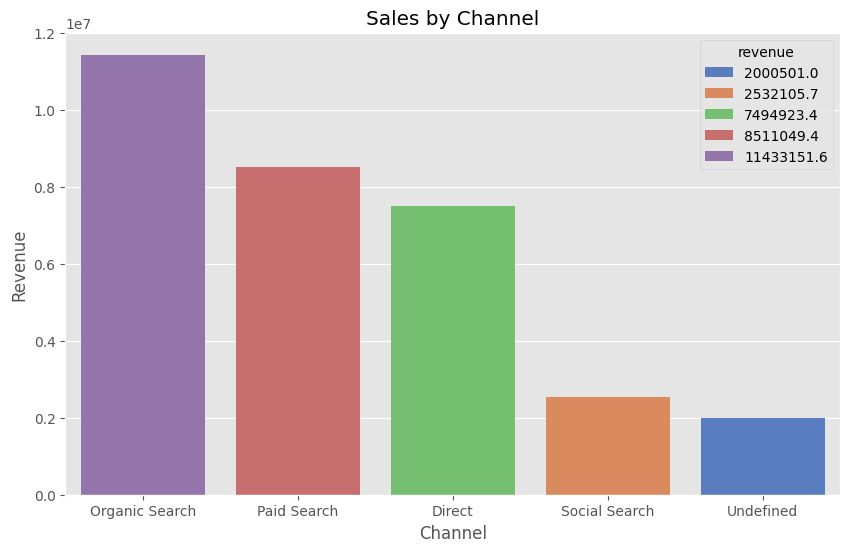

In [ ]:
sales_by_channel = df.groupby("channel")["price"].sum().reset_index(name="revenue").sort_values(by="revenue", ascending=False)
print(sales_by_channel)

plt.figure(figsize=(10,6))
sns.barplot(data=sales_by_channel, x="channel", y="revenue", palette="muted", hue="revenue")

plt.title("Sales by Channel")
plt.ylabel("Revenue")
plt.xlabel("Channel")

          channel     revenue
1  Organic Search  11433151.6
2     Paid Search   8511049.4
0          Direct   7494923.4
3   Social Search   2532105.7
4       Undefined   2000501.0


Text(0.5, 0, 'Device')

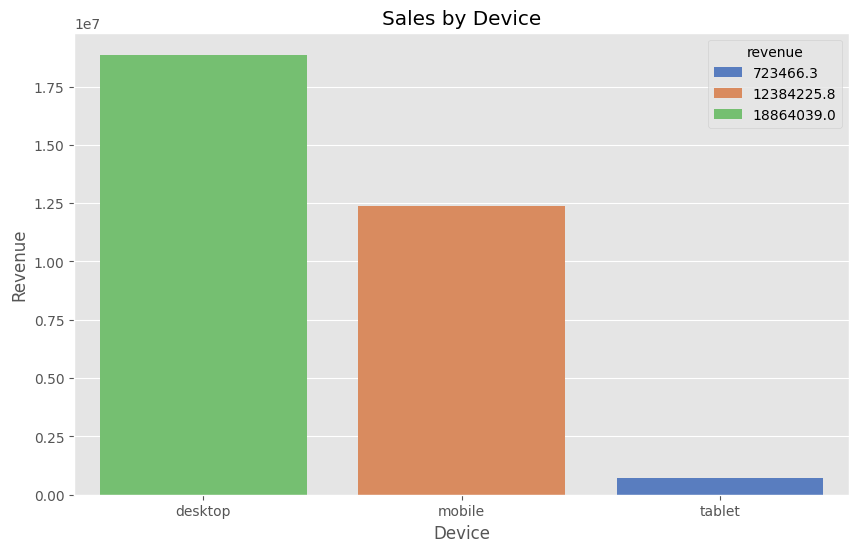

In [ ]:
sales_by_device = df.groupby("device")["price"].sum().reset_index(name="revenue").sort_values(by="revenue", ascending=False)
print(sales_by_channel)

plt.figure(figsize=(10,6))
sns.barplot(data=sales_by_device, x="device", y="revenue", palette="muted", hue="revenue")

plt.title("Sales by Device")
plt.ylabel("Revenue")
plt.xlabel("Device")

In [ ]:
pivot = pd.pivot_table(df, index="channel", values="ga_session_id", aggfunc="nunique")
pivot = pivot.sort_values(by="ga_session_id", ascending=False)
print(pivot)

                ga_session_id
channel                      
Organic Search         124425
Paid Search             94341
Direct                  81382
Social Search           27914
Undefined               21483


In [ ]:
pivot = pd.pivot_table(df, index="device", values="ga_session_id", aggfunc="nunique")
pivot = pivot.sort_values(by="ga_session_id", ascending=False)
print(pivot)

         ga_session_id
device                
desktop         204429
mobile          137267
tablet            7849


In [ ]:
print(sns.palettes.SEABORN_PALETTES.keys())

dict_keys(['deep', 'deep6', 'muted', 'muted6', 'pastel', 'pastel6', 'bright', 'bright6', 'dark', 'dark6', 'colorblind', 'colorblind6'])


In [ ]:
pivot = pd.pivot_table(df, index="category", values="ga_session_id", aggfunc="nunique")
pivot = pivot.sort_values(by="ga_session_id", ascending=False)
print(pivot)

                                      ga_session_id
category                                           
Bookcases & shelving units                     7630
Chairs                                         5952
Sofas & armchairs                              4301
Tables & desks                                 2941
Beds                                           2926
Cabinets & cupboards                           2318
Outdoor furniture                              2229
Children's furniture                           1702
Chests of drawers & drawer units               1452
Bar furniture                                  1092
Nursery furniture                               394
Café furniture                                  359
Sideboards, buffets & console tables            132
Room dividers                                   110


In [ ]:
pivot = pd.pivot_table(df, index="category", values="ga_session_id", aggfunc="nunique")
pivot = pivot.sort_values(by="ga_session_id", ascending=False).sort_values(ascending=False, by="ga_session_id").head(10)
print(pivot)

                                  ga_session_id
category                                       
Bookcases & shelving units                 7630
Chairs                                     5952
Sofas & armchairs                          4301
Tables & desks                             2941
Beds                                       2926
Cabinets & cupboards                       2318
Outdoor furniture                          2229
Children's furniture                       1702
Chests of drawers & drawer units           1452
Bar furniture                              1092


In [ ]:
top_10_categories = df.groupby("category")["ga_session_id"].count().sort_values(ascending=False).head(10).index
df_top = df[df["category"].isin(top_10_categories)]

grouped = df_top.groupby(["category", "country"])["ga_session_id"].count().reset_index(name="sales_count")
top_5_countries_per_category = grouped.sort_values(["category", "sales_count"], ascending=[True, False]).groupby("category").head(5)

print(top_5_countries_per_category)


                             category         country  sales_count
70                      Bar furniture   United States          487
25                      Bar furniture           India           96
11                      Bar furniture          Canada           83
69                      Bar furniture  United Kingdom           34
60                      Bar furniture           Spain           23
163                              Beds   United States         1298
108                              Beds           India          236
86                               Beds          Canada          218
162                              Beds  United Kingdom           97
101                              Beds          France           56
264        Bookcases & shelving units   United States         3374
204        Bookcases & shelving units           India          734
181        Bookcases & shelving units          Canada          591
263        Bookcases & shelving units  United Kingdom         

In [ ]:
date_stats = df.groupby("date").agg(session_count=("ga_session_id", "count"),total_revenue=("price", "sum")).reset_index()


<Figure size 1200x600 with 0 Axes>

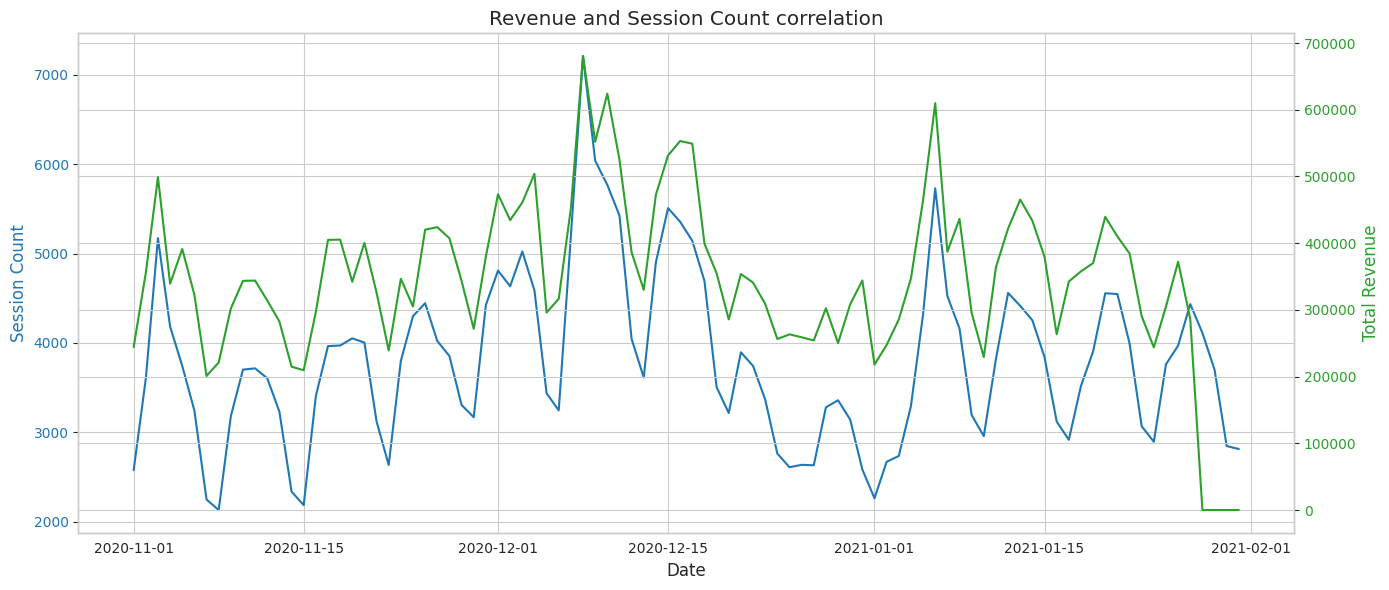

In [ ]:
plt.figure(figsize=(12, 6))

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 6))

color1 = "tab:blue"
ax1.set_xlabel("Date")
ax1.set_ylabel("Session Count", color=color1)
ax1.plot(date_stats["date"], date_stats["session_count"], color=color1, label="Session Count")
ax1.tick_params(axis="y", labelcolor=color1)


ax2 = ax1.twinx()
color2 = "tab:green"
ax2.set_ylabel("Total Revenue", color=color2)
ax2.plot(date_stats["date"], date_stats["total_revenue"], color=color2, label="Total Revenue")
ax2.tick_params(axis="y", labelcolor=color2)

plt.title("Revenue and Session Count correlation")
fig.tight_layout()
plt.show()

In [ ]:
stat_sess, p_sess = shapiro(date_stats["session_count"])
print(f"Session count: W={stat_sess:.3f}, p-value={p_sess:.5f}")

stat_rev, p_rev = shapiro(date_stats["total_revenue"])
print(f"Total revenue: W={stat_rev:.3f}, p-value={p_rev:.5f}")

Session count: W=0.969, p-value=0.02620
Total revenue: W=0.951, p-value=0.00172


In [ ]:
corr_coef, p_value = spearmanr(date_stats["session_count"], date_stats["total_revenue"])

print(f"Spearman correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.865
P-value: 9.755923586156614e-29


We first tested whether the data followed a normal distribution and found that they did not(p_value < 0.05 in both). Therefore, we chose to use Spearman’s rank correlation coefficient, which does not assume normality. Spearman’s correlation showed a strong and statistically significant positive relationship between session count and total revenue(p_value << 0.05). This indicates that as the number of sessions increases, total revenue tends to increase as well.

In [ ]:
stat_sess, p_sess = shapiro(top_continents_by_orders["order_count"])
print(f"Session count: W={stat_sess:.3f}, p-value={p_sess:.5f}")

stat_rev, p_rev = shapiro(top_continents_by_revenue["revenue"])
print(f"Total revenue: W={stat_rev:.3f}, p-value={p_rev:.5f}")

Session count: W=0.851, p-value=0.24272
Total revenue: W=0.854, p-value=0.25150


In [ ]:
corr_coef, p_value = spearmanr(top_continents_by_orders["order_count"], top_continents_by_revenue["revenue"])

print(f"Spearman correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 1.000
P-value: 0.0


In [ ]:
category_corr = df.groupby("continent").agg({
    "price": "sum",
    "ga_session_id": "count"
}).sort_values(by="price",ascending=False).head(3).reset_index()

print(category_corr)

  continent       price  ga_session_id
0  Americas  17665280.0         193179
1      Asia   7601298.3          83113
2    Europe   5934624.2          65135


The Spearman correlation coefficient between session count and total revenue is 1.000 with a p-value of 0.0, indicating a perfect positive monotonic relationship. However, this result is based on only three data points (continents), which limits the statistical reliability of the conclusion. Despite this, the overall pattern clearly suggests that higher user activity is strongly associated with higher revenue across regions.

In [ ]:
sales_by_channel_date = df.groupby("channel").agg({
    "price":"sum",
    "ga_session_id": "count"
}).reset_index()

In [ ]:
sales_by_channel_date.head()

,channel,price,ga_session_id
0,Direct,7494923.4,81382
1,Organic Search,11433151.6,124425
2,Paid Search,8511049.4,94341
3,Social Search,2532105.7,27914
4,Undefined,2000501.0,21483


In [ ]:
corr_coef, p_value = spearmanr(sales_by_channel_date["price"], sales_by_channel_date["ga_session_id"])

print(f"Spearman correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 1.000
P-value: 1.4042654220543672e-24


The Spearman correlation coefficient of 1.000 indicates a perfect positive monotonic relationship between the sales of the channels compared. The extremely low p-value shows this correlation is highly statistically significant.

In [ ]:
corr_categories = df.groupby("category").agg({
    "price":"sum",
    "ga_session_id": "count"
}).sort_values(by="price",ascending=False).reset_index().head(5)

In [ ]:
corr_categories.head()

,category,price,ga_session_id
0,Sofas & armchairs,8388254.5,4301
1,Chairs,6147748.8,5952
2,Beds,4919725.0,2926
3,Bookcases & shelving units,3640818.1,7630
4,Cabinets & cupboards,2336499.5,2318


In [ ]:
corr_coef, p_value = spearmanr(corr_categories["price"], corr_categories["ga_session_id"])

print(f"Spearman correlation coefficient: {corr_coef}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.3
P-value: 0.6238376647810728


The Spearman correlation coefficient of 0.3 indicates a weak positive association between price and ga_session_id. However, the high p-value (0.624) means this correlation is not statistically significant. Thus, there is no sufficient evidence to conclude a meaningful correlation between these variables.

In [ ]:
sales_by_date = df[df['category'].notna()].groupby("date").agg(
    verified_users=("verification", lambda x: ((x == 1).sum())),
    unverified_users=("verification", lambda x: ((x == 0).sum()))
).reset_index()

In [ ]:
sales_by_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              88 non-null     datetime64[ns]
 1   verified_users    88 non-null     Int64         
 2   unverified_users  88 non-null     Int64         
dtypes: Int64(2), datetime64[ns](1)
memory usage: 2.4 KB


In [ ]:
sales_by_date.head()

,date,verified_users,unverified_users
0,2020-11-01,14,267
1,2020-11-02,23,345
2,2020-11-03,36,525
3,2020-11-04,19,351
4,2020-11-05,22,366


In [ ]:
stat_s, p_value = shapiro(sales_by_date["verified_users"])
print(f"stat: W={stat_sess:.3f}, p-value={p_sess}")

stat_s, p_value = shapiro(sales_by_date["unverified_users"])
print(f"stat: W={stat_rev:.3f}, p-value={p_rev}")

stat: W=0.954, p-value=1.0121314328431947e-10
stat: W=0.947, p-value=8.29558567896007e-12


In [ ]:
stat, p_value = mannwhitneyu(sales_by_date["verified_users"],sales_by_date["unverified_users"])
print(f"P-value: {p_value}")

P-value: 2.1690191010358923e-30


The p-value is extremely small, indicating that the difference between the two groups is highly statistically significant

We conducted exploratory and statistical analysis of our dataset using Python to better understand the underlying patterns and distributions. Additionally, we will build more advanced and comprehensive visualizations using Tableau to gain deeper insights and present the results in a more interactive and intuitive format.

Link to dashboard:https://public.tableau.com/views/SalesAnalysis_17490592758650/SalesAnalysis?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link